In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lz4 import frame

In [180]:
np.array(-128, dtype="int8")

array(-128, dtype=int8)

In [188]:
view_binary(np.array([-127, -126, 0, 1, 2], dtype="int8"))

['10000001', '10000010', '00000000', '00000001', '00000010']

In [184]:
x = np.array([-3, -2, -1, 0, 1, 2, 3, 4, 126, 127], dtype="int8")
gray(x)

array([-127, -126, -128,    0,    1,    3,    2,    6,   65,   64],
      dtype=int8)

In [149]:
def nbits(dtype):
    return np.dtype(dtype).itemsize * 8

def gray(d):
    ad = np.abs(d)
    g = ad ^ (ad >> 1)
    g[d < 0] += 2**(nbits(d.dtype)-1) - 1
    return g

def bitshuffle(d):
    nb = nbits(d.dtype)
    out = []
    scalar = 2**np.arange(nb)
    scalar.shape = (1, nb)
    for i in range(nb):
        buf = (d >> i) & 1
        buf.shape = (-1, nb)
        buf = np.sum(buf * scalar, axis=1, keepdims=True)
        out.append(buf)
    out = np.concatenate(out, axis=0).ravel()
    return out.astype(f"uint{nb}")

def bitshuffle2(d):
    """Only works for uint8"""
    y = np.unpackbits(d[None], axis=0, bitorder="little")
    x = np.packbits(y, axis=1, bitorder="little")
    assert np.all(x.ravel() == bitshuffle(d))
    return x.ravel()

    
def compress(d, use_gray=True, use_bitshuffle=True):
    din = d.copy()
    if use_gray:
        din = gray(din)
    if use_bitshuffle:
        din = bitshuffle(din)
    return frame.compress(din)

def gen_noise(scale, cen=0, size=1024, dtype="int8"):
    nb = nbits(dtype)
    n = np.random.normal(loc=cen, scale=scale, size=size)
    n = np.around(n).clip(-2**(nb-1), 2**(nb-1)-1).astype(dtype)
    return n

def view_binary(d):
    nb = nbits(d.dtype)
    bits = [np.binary_repr(i, width=nb) for i in d]
    return bits

In [150]:
NAVG = 100
SIZE = 1024
CEN = 0
dtype = "int8"
nb = nbits(dtype)
scales = 2.**np.arange(-1, nb)

ans = np.empty((scales.size, 3))

for i, scale in enumerate(scales):
    noise = gen_noise(scale, cen=CEN, size=(NAVG, SIZE), dtype=dtype)
    buf = np.mean([len(compress(noise[j])) for j in range(NAVG)])
    ans[i, 0] = buf / (SIZE * nb / 8)
    buf = np.mean([len(compress(noise[j], use_gray=False)) for j in range(NAVG)])
    ans[i, 1] = buf / (SIZE * nb / 8)
    buf = np.mean([len(compress(noise[j], use_gray=False, use_bitshuffle=False)) for j in range(NAVG)])
    ans[i, 2] = buf / (SIZE * nb / 8)

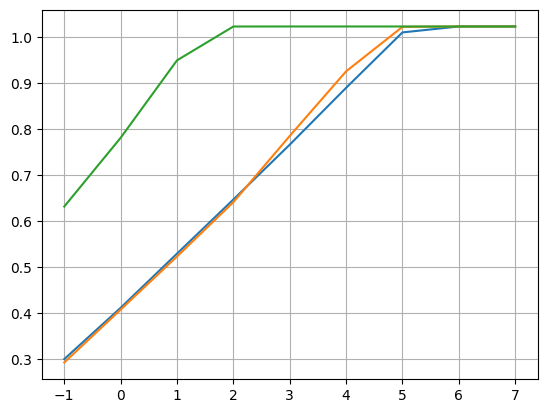

In [151]:
plt.figure()
plt.plot(np.log2(scales), ans)
plt.grid()
plt.show()

In [248]:
scale = 1
noise = gen_noise(scale, cen=CEN, size=SIZE, dtype=dtype)

In [249]:
print(noise.size)
print(len(compress(noise)))

1024
418


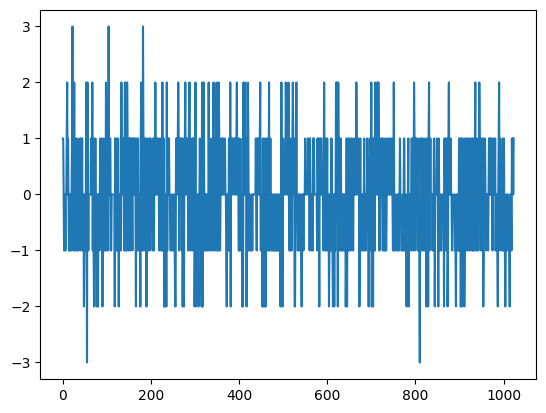

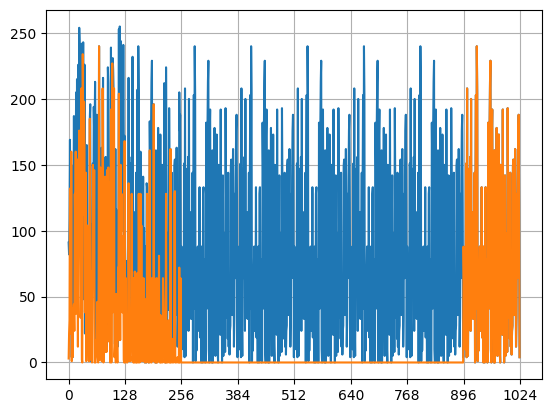

In [250]:
plt.figure()
plt.plot(noise)
plt.show()

plt.figure()
plt.plot(np.arange(noise.size), bitshuffle(noise))
plt.plot(np.arange(noise.size),bitshuffle(gray(noise)))
plt.xticks(1024 // 8 * np.arange(9))
plt.grid()
plt.show()

The noise has a lot of small values (absolute value). The Gray encoding maps the small positive values to small numbers and the small negative numbers to large numbers. Thus, the Gray encoded noise has a bunch of 00000001, 00000010 etc and 10000000, 11000000 etc. The bitshuffle then gives numbers that are small (corresponding to the first 2 bits, 0-256 here since the size is 1024) and large (the last bit, 896-1024 here) but all 0s in the middle due to the middle bits always being 0. They're only non-zero if a large signal comes in.

In [251]:
# only occupied bits are 1, 7, and 8.
view_binary(np.unique(gray(noise)))

['10000000',
 '10000001',
 '10000010',
 '00000000',
 '00000001',
 '00000010',
 '00000011']

In [265]:
bgn = bitshuffle(gray(noise))
# find largest zero chunk
np.diff(np.nonzero(bgn)[0]).argmax()

197

In [267]:
np.nonzero(bgn)[0]

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   54,   55,   56,
         57,   58,   62,   63,   64,   65,   66,   68,   69,   70,   71,
         72,   73,   74,   75,   76,   77,   78,   80,   81,   82,   83,
         84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   95,
         96,   98,   99,  100,  101,  102,  103,  104,  105,  106,  108,
        109,  110,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  127,  129,  130,  131,  134,  135,
        136,  137,  138,  139,  140,  141,  142,  143,  144,  145,  146,
        148,  150,  151,  154,  156,  157,  159,  160,  162,  163,  164,
        165,  166,  167,  168,  169,  170,  171,  1